# Ising models and Metropolis algorithm

In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

import numpy as np

### Ising model: The H atom of phase transitions

- Ising models are simple spin lattice models widely used to study phase transitions. Many aspects of phase transitions are universal and independent of microscopic details of interactions. Hence, one wants as simple a model capable of displaying phase transitions as possible! Ising models fit the bill perfectly, and one could even obtain analytical solutions (1D and 2D).

- We are going to learn that phase transitions are possible in 2D and 3D. This notebook focuses on simulating 2D lattice and calculating thermodynamic observables. 

- Ising Models are defined by Hamiltonian encoding the nature of interactions between spins $i$ and $j$ (for nearest neighbors $|i-j|=1$) and interactions of spins with an external field $B$

$$\boxed{H([s])= \sum_{\langle ij \rangle} J_{ij}s_i s_j - \mu B \sum_i s_i}$$

- The partition function is the sum of all possible microstates or, in the case of Ising models, all possible spin configurations!

$$\boxed{Z=\sum_{[s]}e^{-H([s])/k_B T}}$$

**Extracting thermodynamics from Ising models**

- Total magnetization, $M$  or Magnetization per spin $m$

$$M([s])=\sum_is_i $$

$$m([s])=\frac{1}{N}\sum_is_i =\frac{M}{N}$$

- Partition function can be defined for fixed valyes of Magnetization as a partial sum over those spin configurations $[s]$ for which $M[s] = M$ 

$$Z(M) = \sum_{[s]} e^{-\beta H([s])} \delta (M-M([s]))$$

- Similarly, Free energy as a function of M can be obtained, allowing us to reason about the probabilities of systems with different degrees of magnetization. 

$$F(M)=-\beta^{-1} log Z(M)$$

**Response functions**

To inform us about fluctuations in energy and magnetization, we compute the following response functions

- **Heat capacity $C_v$**

$$ C_V(T) = \Big (\frac{\partial E}{\partial T} \Big )_V= \frac{1}{k_B T^2} \big(\langle E^2 \rangle-\langle E \rangle^2 \big) $$

- **Susceptibility $\chi$**

$$\chi_T=\Big (\frac{\partial M}{\partial B} \Big )_T= \frac{1}{k_B T} \big(\langle M^2 \rangle-\langle M \rangle^2 \big) $$

### Setting up spin lattice 

[[ 1 -1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1  1 -1 -1 -1]
 [ 1 -1 -1 -1  1  1  1 -1]
 [-1 -1  1  1 -1  1  1 -1]
 [-1 -1 -1 -1  1 -1  1  1]
 [ 1  1 -1  1 -1  1 -1 -1]
 [ 1  1 -1  1  1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1  1]]


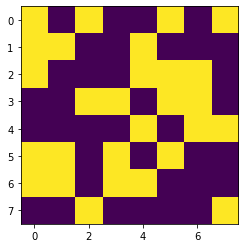

In [3]:
spins = np.random.choice([-1,1],size=(8,8))

print(spins)

plt.imshow(spins)

### Enforcing periodic boundary conditions

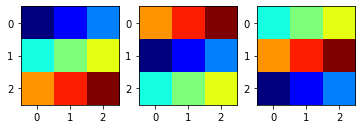

In [4]:
X = np.array([[1, 2 ,3], 
              [4, 5, 6],
              [7, 8, 9]])
Y = np.roll(X, 1, axis=0)
Z = np.roll(X, -1, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.imshow(X, cmap='jet')
ax2.imshow(Y, cmap='jet')
ax3.imshow(Z, cmap='jet')

In [139]:
def get_E(spins, J=1, B=0):
    '''Compute energy of spin-lattice by taking the product of spin 
    lattice with itself shifted in four directions using
    via numpy roll''' 
      
    z = np.roll(spins, 1, axis = 0) + np.roll(spins, 1, axis = 1)
    E = np.sum( -J*spins*z) - B*np.sum(spins)
    
    return E 

def get_E2(spins,J=1,B=0):  
    '''Compute energy of spin lattice by iterating over every spin 
    and using modulo to enforce periodic bondary conditions
    e.g (N-2)%N=N-2,  (N-1)%N = N-1 and N%N=0''' 

    N =len(spins)
    E = 0
    for i in range(N):
        for j in range(N):   
            z = spins[(i+1)%N, j] + spins[(i-1)%N, j] + \
                spins[i,(j+1)%N]  +  spins[i,(j-1)%N]
            E += -J*z*spins[i,j]/2 
            
    return E - B*np.sum(spins) 

In [140]:
get_E(spins) == get_E2(spins)
#get_dE(spins, 1, 2)

True

In [33]:
def get_dE(spins, i, j, J=1, B=0):
    '''Compute change in energy of 2D spin lattice 
    after flipping a spin at a location (i,j)''' 
    
    N = len(spins)
    
    z  = spins[(i+1)%N, j] + spins[(i-1)%N, j] + \
             spins[i, (j+1)%N] + spins[i, (j-1)%N] 
             
    dE = 2*spins[i,j]*(J*z + B)
    
    return dE

### Sampling Boltzmann distribution: MC vs MCMC

**MC sampling**
- How to compute the expectation value of a thermodynamic variable $A$. In theory everything is simple: we need to sample from the exponential distribution.

$$P(E_i)= \frac{e^{-\beta E_i}}{\sum_i e^{-\beta E_i}}$$

$$\langle A\rangle = \sum_i A_iP(E_i) \approx\frac{1}{N}\sum_{i=1}^N \underbrace{A_i}_{{\rm chosen}\ {\rm acc.}\ {\rm to}\ P(E_i)}$$

- In practice the brute force MC sampling of exponential fails even for the smallest of ising lattices. 

**Problems with MC**
- There is an astronomical number of states, $i = 1... N^2$! 
- Most of these microstates make exponentially small contribution to probability distribution! $P(E_i)$
- Brute force MC will not be efficient for sampling important portions of $P(E_i)$.
- **Conclusion: We need Importance sampling!**

**MCMC Sampling**

-  Instead of ranodmly picking states we generate chain of states. This sampling technique is known as Markov Chain Monte Carlo (MCMC). MCMC generates random walks in configuration space and is more efficient at finding sampling states than basic MC.



### Generating chains! Master Equation and Detailed Balance

**Random chain**

- In simple MC each sampled state $X_i$ at step $i$ is independet of the next or previous steps. 

- Thus, MC sampling generates totally uncorrelated samples which is good for rapid convergence according to Central Limit Theorem. But as we remarked above the samples are most likely not covering important areas!

$$P(X_N, ..., X_2, X_1) = P_N(X_N)\cdot ... P_2(X_2) \cdot P_1(X_1)$$

**Markov chain:**

- In simple MCMC each sampled state $X_i$ at steo $i$ is generated from $i-1$.
- This introduces correlations between samples which means slower covnergence to the mean.
- On the other hand MCMC find the important areas for sampling much faster so in the hand it wins big compared to MC.

$$P(X_N, ..., X_2, X_1) = P_N(X_N)\cdot ... P_3(X_3| X_2) \cdot P_2(X_2| X_1)... P_1(X_1)$$


- The probability of picking state $i+1$ given taht we started from $i$ is referred to as **transition probability** $T_{ij}$ 

$$T_{21} = T(X_2 \leftarrow X_1) = P(X_2|X_1)$$

- As a probability it should be normalized:

$$\sum_{X} T_{XX'} = 1$$

- Probability of being at $X$ at $t+\Delta t$ given a prior state at $(X',t)$ can be written in terms of $T_{XX'}$ as:

$$P(X, t+\Delta t) = \sum_{X'}  T_{XX'} P(X', t)$$

- Subtracting P(X,t) from both states we can obtain equation of motion for Markov chain.

$$P(X, t+\Delta t) -P(X,t)= \sum_{X'}  T_{XX'} P(X', t) - P(X, t)\sum_{X'} T_{X'X}$$

**Master equation: A continuity equation in probability space.**

$$\boxed{\frac{\partial P(X,t)}{\partial t} = \sum_{X'}  w_{X X'} P(X', t) - \sum_{X'} w_{X' X} P(X, t)}$$

- Where we have defined transition rates as the limit of $w_{X'X} = lim_{\Delta t \rightarrow 0}\frac{T_{X'X} (\Delta t)}{\Delta t}$

### Detailed Balance = Equilibrium

<br>

$$\boxed{\frac{\partial P(X,t)}{\partial t}  = \sum_{X'} P(X', t) w_{XX'} - \sum_{X'} P(X, t) w_{X' X}}=0$$

<br>

$$\boxed{  w_{ij}\cdot p_j =  w_{ji} \cdot p_i  }$$

**Master equation for a two state dynamics**

$$\frac{dP(x_1,t)}{dt} = w_{12} p_2 - w_{21} p_1$$

$$\frac{dP(x_2,t)}{dt} = w_{21} p_1  -  w_{12} p_2$$

- In the equilibrium we see that equilibrium is established when probability ratio matches the ratio of tranistions $\frac{p_1}{p_2} = \frac{w_{12}}{w_{21}}$
- In the $NVT$ ensemble we have an explicit requirment for transition rates $\frac{p_1}{p_2} = e^{-\beta (E_1-E_2)} = \frac{w_{12}}{w_{21}}$

### Example of detailed balance: Isomerisation reaction

- To illustrate the approach to equilibrium in a reversible A ↔ B reaction using a Markov chain model, let's consider the following scenario and Python simulation:

**Scenario Setup**
In this chemical interconversion reaction:

- $A \rightarrow B$ with probability $p$
- $B \rightarrow A$ with probability $q$

**Markov Chain Model**

- The system has two states (A, B), with transitions defined by a transition matrix.
- Simulate Transitions: The simulation determines the system's state after each step by following the transition probabilities.
- Calculate Equilibrium: We observe how the system's state probabilities evolve over $N$ steps to reach equilibrium.

In [15]:
# Transition probabilities
p = 0.3  # Probability of going from A to B
q = 0.7  # Probability of going from B to A

# Transition matrix
transition_matrix = np.array([
    [1-p, p],  # From A to A, B
    [q, 1-q]   # From B to A, B
])

# Initial state (0 for A, 1 for B)
current_state = 0

# Number of steps to simulate
n_steps = 1000

# Record the state at each step to visualize the approach to equilibrium
state_history = np.zeros((n_steps, 2))  # Create a history record for both states A and B
state_history[0, current_state] = 1

# Simulate the Markov chain
for step in range(1, n_steps):
    current_state = np.random.choice([0, 1], p=transition_matrix[current_state])
    state_history[step, current_state] = 1

# Calculate cumulative probabilities over time to show how probabilities stabilize
cumulative_probabilities = np.cumsum(state_history, axis=0) / np.arange(1, n_steps+1).reshape(-1, 1)

- As the number of steps increases, the fraction of time the system spends in each state $A$ and $B$ should converge to the theoretical equilibrium probabilities. These are derived from the detailed balance conditions $p \cdot \pi_A = q \cdot \pi_B$ and the normalization condition $\pi_A + \pi_B = 1$.
- This simulation visually demonstrates the concept of reaching equilibrium in a reversible reaction through a Markov process, which is essential in understanding statistical thermodynamics.

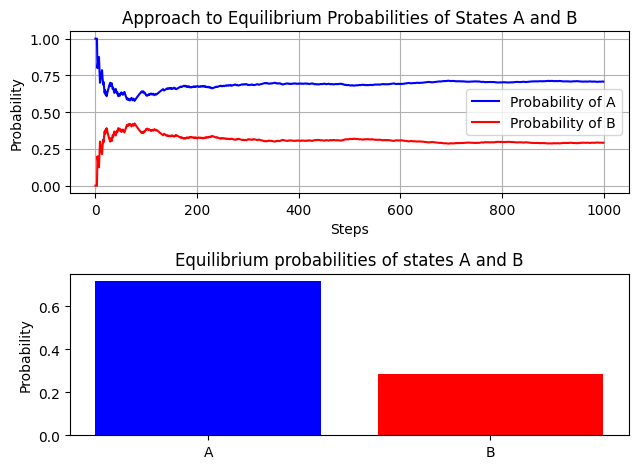

In [16]:
# Plotting the results
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(cumulative_probabilities[:, 0], label='Probability of A', color='blue')
ax1.plot(cumulative_probabilities[:, 1], label='Probability of B', color='red')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Probability')
ax1.set_title('Approach to Equilibrium Probabilities of States A and B')
ax1.legend()
ax1.grid(True)


# Plotting the results
ax2.bar(['A', 'B'], [state_record[0]/n_steps, state_record[1]/n_steps], color=['blue', 'red'])
ax2.set_ylabel('Probability')
ax2.set_title('Equilibrium probabilities of states A and B')
fig.tight_layout()

### How to pick the moves for Markov chain?

- Now it is time to consider practical aspects of conducting MCMC. How to pick states and transitions?

$$[transition] =  [accept/reject] \cdot [move]$$

$$T(X' \leftarrow X) = \alpha_{X' X}\cdot A_{X' X} $$

- We have great freedom in picking states and moves as long as we satisfy the detailed balance! E.g as long as the ratio of transition probabilities matches ration of Botlzman factors!

- The simplest case for move is to pick one spins at random per iteration:

$$\alpha_{X' X} = \frac{1}{L^2}$$ 

- For transitions we adopt criteria that favors our chain to explore low energy (high probability) configurations:

- If $p(X') < p(X),\,\,\,\,$ $A_{X'X}=\frac{p(X')}{p(X)}$
- If $p(X') \geq p(X),\,\,\,$ $A_{X'X}=1$

$$\frac{T_{X'X}}{T_{XX'}} = \frac{1/L^2}{1/L^2} \cdot \frac{p(X')/p(X)}{1}$$

## Metropolis algorithm

${\bf i. Initialization.}$ Generate some initiaal configuration for spins $[s_0]=(s_1,...s_N)$. For instnace Choosing random orientation for each spins $(+1, -1)$ or giving them  the same orientation. 

${\bf ii. Attempt\,\, spin\,\, flip.\,\,}$ Pick a spin at random and flip it. E.g multiply by -1 so that +1 state becomes -1 and vice versa. this generated a new configuration $[s_1]$

${\bf iii. Acceptance/Rejection}$ Evaluate energy differene between old configuration $[s_{0}]$ and new one $[s_{1}]$ with flipped spin which has created in previous step. The $\Delta E=E_{1}-E_{0}$ is used for deciding weather the move is accepted or rejected in a way that is consistent with Boltzman distribution: 

$$w=\frac{P[s_{1}]}{P[s_{0}]}=exp\big(-\beta[E_{1}-E_{0}] \big ) $$

This is done by generating a unifor random number $r$ between $[0,1]$ and 

(a) if $r  \leq w$ Accept the spin flip thereby keeping $[s_1]$ and proceeding to try new spin flip via step ii.  

(b) if $r  > w$ reject the spin flip and set  $[s_1]=[s_0]$ and proceeding to try a new spin flip via step ii.

### Code for running 2D ising MCMC Simulations

- If numba is installed, uncomment to benfit from jit acceleration!
- To speed benchmarks to assess how long simulation would take

In [156]:
from numba import njit
import numpy as np

@njit
def run_ising2d(N, T, J, B, n_steps, out_freq):
    '''Basic Metropolis Monte Carlo simulator of 2D Ising model
    ---
    spins:    (int, int) 2D numpy array
    T, J, B:  (floats) corresponding to temperature, coupling and field variables
    n_steps:  (int), simulation steeps
    out_freq: (int), How often to compute and save data
    ---
    Returns:
    E/N: per-spin energy over n steps  
    M/N: per-spin magnetization over n steps 
    S:   2D spin configurations over n steps 
    '''
    
    #### Initialize simulation
    spins = 2*(np.random.rand(N, N) < 0.5) - 1
    
    M_t   = np.sum(spins)

    # We use explicit looping required by njit accelearation
    E_t   = -B*M_t 
    for i in range(N):
        for j in range(N): 
            z    = spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[i,(j+1)%N] + spins[i,(j-1)%N]
            E_t += -1/2 * J * z

    #### Run MC Simulation
    S, E, M = [], [], []
    for step in range(n_steps):
        
        # Pick random spin
        i, j = np.random.randint(N), np.random.randint(N)

        # Compute energy change resulting from a flip of spin at i,j
        z  = spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[i, (j+1)%N] + spins[i, (j-1)%N] 
        dE = 2*spins[i,j]*(J*z + B)
        dM = 2*spins[i,j]

        # Metropolis condition
        if np.exp(-dE/T) > np.random.rand():
            spins[i,j] *= -1 
            E_t        += dE
            M_t        += dM

        # Save Thermo data
        if step % out_freq == 0:
            M.append(M_t/N**2)
            E.append(E_t/N**2)
            S.append(spins.copy())

    return S, E, M

In [160]:
#Simulation Parameters
params = {'N':40,
          'J':1,
          'B':0, 
          'T': 4,
          'n_steps': 100000, 
          'out_freq': 10}

# Simulation
S, E, M = run_ising2d(**params)

In [158]:
np.array(S).shape, np.array(E).shape, np.array(M).shape

((1000, 40, 40), (1000,), (1000,))

### Visualize simulations

In [6]:
@widgets.interact(i=(0, 10000-1))
def plot_image(i=0):
    
    fig, ax  = plt.subplots(ncols=3, figsize=(10,4))
    
    ax[0].pcolor(S[i])
    ax[1].plot(E)
    ax[2].plot(M)
    
    ax[0].set(ylabel='$i$', xlabel='j')
    ax[1].set(ylabel='$E$', xlabel='steps')
    ax[2].set(ylabel='$M$', xlabel='steps')
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=9999), Output()), _dom_classes=('widget-interact…

### Carry out explorative simulations

- How do we know if the simulation has done enough sampling? How do we assess convergence and errors? 
- Test the dependence of observables on system size.
- Test the dependence of observables on initital conditions.
- Vary intensive parameters, e.g., temperature and field strength. Investigate changes in observables such as magnetization, energy, susceptibility, heat capacity.
- Think about alternative ways of accelerating and enhancing the sampling.

#### Parameter sweeps 

In [161]:
#Simulation Parameters
params = {'N':40,
          'J':1,
          'B':0, 
          'T': 4,
          'n_steps': 1000000, 
          'out_freq': 10}

Ts = np.linspace(1, 4, 40) 
Es, Ms, Cs, Xs = [], [], [], []  

for T in Ts:
    
    params['T']=T
    
    S, E, M = run_ising2d(**params)

    # Save last 80% percent of data
    idx = int(len(E) * 0.2) 
    
    E = E[idx:]
    M = M[idx:]
    
    Es.append(np.mean(E))
    Ms.append(np.mean(M))
    
    Cs.append(np.var(E)/T**2) 
    Xs.append(np.var(M)/T)

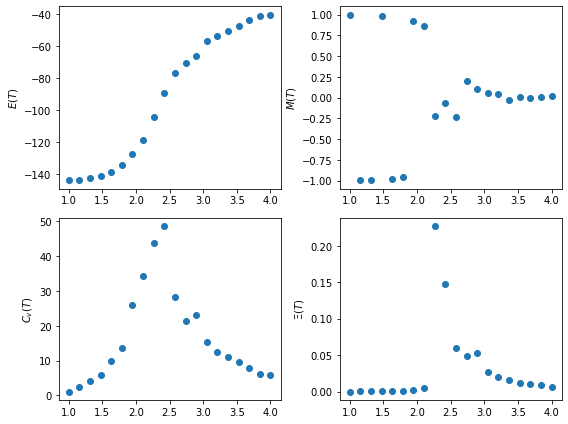

In [114]:
fig, ax  = plt.subplots(ncols=2, nrows=2, figsize=(8,6))

ax[0,0].scatter(Ts, Es)
ax[0,0].set(ylabel='$E(T)$')

ax[0,1].scatter(Ts, Ms)
ax[0,1].set(ylabel='$M(T)$')

ax[1,0].scatter(Ts, Cs)
ax[1,0].set(ylabel='$C_v(T)$')

ax[1,1].scatter(Ts, Xs)
ax[1,1].set(ylabel='$\Xi(T)$')
fig.tight_layout()

### Autocorrelation functions

In [ ]:
def autocorr(x):
    n = len(x)
    variance = x.var()
    x = x - x.mean()
    result = np.correlate(x, x, mode='full')[-n:]
    result /= variance * np.arange(n, 0, -1)
    return result

M = np.random.randn(1000)  # Example data; replace with your magnetization array
acorr = autocorr(M)
plt.plot(acorr/acorr[0])
plt.xlabel('Steps, $n$')
plt.ylabel(r'$\langle M(t)M(t+n) \rangle$')
plt.show()

### Problems

#### Problem-1

Revisit the example MCMC simulation for determining $\pi$ value. Vary the size of the displacement to determine the optimal size that generates quickest convergence to the value of $\pi$


#### Problem-2 

Carry out MC simulation of 2D ising spin model for various lattice sizes $N= 16,32, 64$ at temperatures above and below critical e.g $T<T_c$ and $T>T_c$.   

- How long does it take to equilibrate system as a function of size and as a function of T?

- Plot some observables as a function of number of samples states to show that the system is carrying out some sort of random walk in the configurational space. 

- How do profiles of Energy vs T, Magnetization vs T and heat capacity vs T, and susceptibility vs T change as a function of size of our lattice. 

- Does $J>0$ and $J<0$ change the nature of phase transition?

#### Problem-3

Compute correlation functions of spin variable, that is how correlated are spins as a function of distance on a lattice, $L$. $C(L)=\langle s_i s_{i+L}\rangle -\langle s_i\rangle \langle s_{i+L}\rangle $ Make sure to account for the periodic boundary conditions! 

> Note that you can pick a special tagged spin and calculate correlation function of taged spin ($s_13$ for instance) with any other as a function of lattice spearation  by averaging over produced MC configurations.  Or you can take advantage of the fact that there are no priviledged spins and average over many spins and average over MC configruations e.g $s_1, s_2, ...$. E.g you can pick a horizontal line of spins and run a summation for each fixed r_ab distance. 

#### Problem-4

Take a 20 by 20 lattice and equilibriate the system with a value of extneral field B equal to +1. 
Now slowly change h to −1 in discrete steps during each of these steps, use the previously equilibriated
configuration as an input to the system to undergo equilibriation again.  

Caluclate average and variance quantities (e.g E, M, C etc). Notice anything interesing :)